# iotSDR Cyclic TX/RX Loop Streaming Demo Notebook:


## Setting up the environment:

* import required python modules
* Load the bitfile containing the block design



In [3]:
from pynq import Overlay
import iotSDR.iotSDR_streams as SDR
import iotSDR.iotSDR_defs as channels
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])

iot_overlay = Overlay('../bitstream/iotSDR_IOT.bit',download=True)


## Setting up the Channels:

* instentiate board resources
* define RX and TX channels



In [5]:
iotSDR = SDR.iotSDR_stream(iot_overlay)

tx_chan   = channels.chan_subGHz_A
rx_chan   = channels.chan_subGHz_B


## Setting up the Carrier frequency:

Setting up the Carrier frequncy requires
* Center frequncy: Center frequncy 
* Channel Spacing: Channel to Channel Frequncy Spacing 
* Channel Number: defines the offset between Center frequncy and Carrier Frequncy 

Carreir Frequncy = Center Frequncy + Channel Spacing x Channel Number 


In [6]:
cent_frequency     = 918e6  # channel carrier freq 
chan_spacing_kHz   = 25     # channel spacing w.r.t carrier freq
chan_number        = 1      # channel offset in multiple of channel spacing w.r.t carrier freq

iotSDR.setFrequency(tx_chan,cent_frequency,chan_spacing_kHz,chan_number)
iotSDR.setFrequency(rx_chan,cent_frequency,chan_spacing_kHz,chan_number)


iotSDR Device: frequency:918000 updated for channel:0 
iotSDR Device: frequency:918000 updated for channel:2 


## Setting up the sampling rate of the Front-end:

Sampling rate of the AT86RF215 has several options

* setp the sampling rate as required



In [8]:
sample_rate = 2e6
print(iotSDR.listSampleRates(rx_chan))
iotSDR.setSampleRate(channels.IOTSDR_RX,rx_chan,sample_rate)


[4000000.0, 2000000.0, 1333333.33, 1000000.0, 800000.0, 666666.67, 500000.0, 400000.0]
iotSDR Device: Requested rate: 2000000.0, Actual Rate: 2000000.00 


## Setting up the TX Stream as cyclic:

* Set up the TX sream
* Activate the TX sream



In [9]:
cyclic_mode = True
tx_stream = iotSDR.initStream(channels.IOTSDR_TX,tx_chan,cyclic_mode)
iotSDR.activateStream(tx_stream)

iotSDR Device: Channel: chan_subGHz_A Tx stream setup 


## Calculate and Plot the TX Data to be transmitted:

* import required python modules
* Calculate the In-Phase and Quadrature-Phase values for a single Tone
* Plot the TX Values



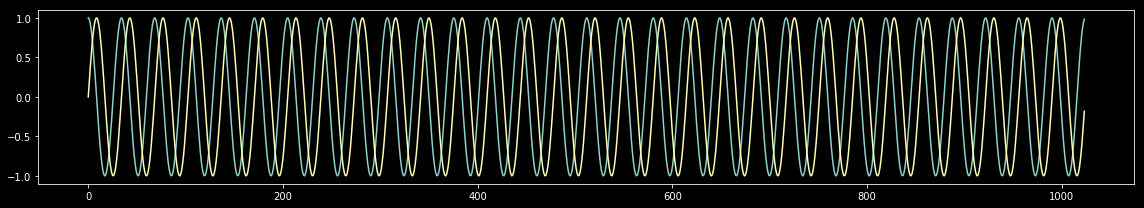

In [10]:

import time


f = 30 #Hz
N = 1*1024

t = np.linspace(0, 1, N,endpoint=False)
real = np.cos(2*np.pi*f*t)*1
imag = np.sin(2*np.pi*f*t)*1

tx_samples = real + 1j*imag


fig, axes= plt.subplots(nrows=1, ncols=1,figsize=(16,3))

n = np.arange(0, N, 1)
axes.plot(n, tx_samples.real[:])
axes.plot(n, tx_samples.imag[:])

plt.tight_layout()
plt.show()


## Create the Buffer for continuous transmission:



In [11]:
"""
Create continous memory buffer for DAC transmit samples
this buffer will be filled up by the streamed samples and transmitted through the RF chip
"""
from pynq import allocate 

totalSamples    = len(tx_samples)
ADC_SAMPLE_BITs = 14

tx_sample_buffer = allocate(shape=(totalSamples*2,), dtype=np.int16)

tx_sample_buffer[0::2] = (2**ADC_SAMPLE_BITs-1)* tx_samples.real
tx_sample_buffer[1::2] = (2**ADC_SAMPLE_BITs-1)* tx_samples.imag


## Setting up the DMA for a contnuous cyclic Buffer:

* setting up the write stream



In [12]:
iotSDR.writeStream(tx_stream,tx_sample_buffer)


Transmission Buffer updated in continous cyclic Mode


## Initialize the RX Stream:

* Initialize the RX Stream
* Activate the RX Stream



In [13]:
rx_stream = iotSDR.initStream(channels.IOTSDR_RX,rx_chan)

iotSDR.activateStream(rx_stream)

iotSDR Device: Channel: chan_subGHz_B stream setup 


## Setup the TX Buffer Size:



In [14]:
"""
Create continous memory buffer for ADC received samples
this buffer will be filled up by the streamed samples recieved from the RF chip
""" 

totalSamples  = 1024*3
rx_sample_buffer = allocate(shape=(totalSamples*2,), dtype=np.int16)


## Visualize the RX Data:

* import required python modules
* Read Data from RX Buffer
* Plot the RX Data



iotSDR Device: Gain:31 updated for channel:0


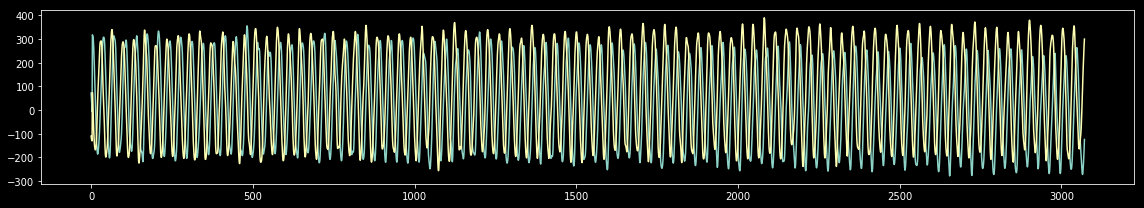

In [15]:

gain = 31
iotSDR.setGain(tx_chan,gain)

total_frames = 1
iotSDR.readStream(rx_stream,rx_sample_buffer)

frame = rx_sample_buffer[::2] + 1j * rx_sample_buffer[1::2]


N = len(frame.real[:])

fig, axes= plt.subplots(nrows=1, ncols=1,figsize=(16,3))
t = np.arange(0, N, 1)

axes.plot(t, frame.real[:N])
axes.plot(t, frame.imag[:N])

plt.tight_layout()
plt.show()

## Close the DMA Channels for TX and RX Streams:

* Close TX Stream
* Close RX Stream



In [16]:
tx_sample_buffer.close()
rx_sample_buffer.close()

In [17]:
iotSDR.deactivateStream(rx_stream)
iotSDR.deactivateStream(tx_stream)